In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Precipitation Analysis

In [9]:
first_row = session.query(measurement).first()
#prints object in the form of a dictionary
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fa449404a50>,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08}

In [10]:
# Find the most recent date in the data set.
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

latest_date

('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.

dateback = dt.date(2017, 8,23) - dt.timedelta(days=365)

dateback

datetime.date(2016, 8, 23)

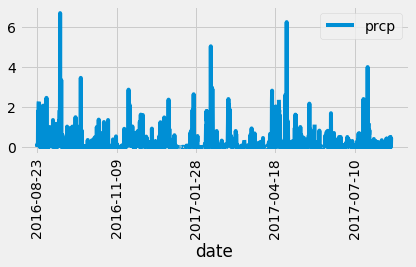

In [12]:
# Perform a query to retrieve the data and precipitation scores
last_12 = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= dateback).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

last_df = pd.DataFrame(last_12, columns=['date', 'prcp'])
last_df

last_df.set_index('date', inplace=True)
last_df.plot()
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
engine.execute('select * from station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [15]:
first_row_too = session.query(station).first()
#prints object in the form of a dictionary
first_row_too.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fa4582331d0>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0}

In [16]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station.station).distinct().count()

station_count

9

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
#station_rows = session.query(station.station, func.count(measurement.station)).\
    #group_by(station.station.desc())

sel = [measurement.station, 
       func.count(measurement.station)]

station_rows = session.query(*sel).\
    group_by(measurement.station).\
    order_by(measurement.station.desc()).all()

station_rows

[('USC00519523', 2669),
 ('USC00519397', 2724),
 ('USC00519281', 2772),
 ('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00513117', 2709),
 ('USC00511918', 1979)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurement.station, 
       func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]

active_station = session.query(*sel).\
    filter(measurement.station == 'USC00519281').all()

active_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

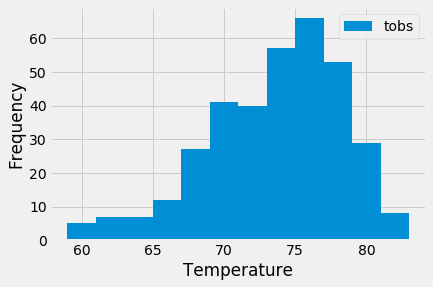

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_12 = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= dateback).\
    order_by(measurement.date).all()

active_df = pd.DataFrame(active_station_12, columns=['date', 'tobs'])

plt.hist(active_df.tobs, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

# Close session

In [23]:
# Close Session
session.close()